<a href="https://colab.research.google.com/github/Giogia/gatys_piu_bello/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [12]:
!pip install moviepy

In [13]:
!imageio_download_bin ffmpeg

Ascertaining binaries for: ffmpeg.


In [0]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow.keras as models

from google.colab import files
from tensorflow import clip_by_value
from tensorflow import enable_eager_execution
from tensorflow.keras.applications.vgg19 import VGG19
from numpy import clip, expand_dims, squeeze, array, random
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from pathlib import Path

import moviepy.video.io.ffmpeg_writer as ffmpeg_writer
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
from IPython.display import HTML, display

CNN

In [0]:
class VGG19_c:

    def __init__(self):

        # here you say where you want to take the features for the content
        self.contentLayers = ['block4_conv2']

        # here you say where you want to take the features for the style
        self.styleLayers = ['block1_conv1',
                              'block2_conv1',
                              'block3_conv1',
                              'block4_conv1',
                              'block5_conv1']
        self.content_layers_num = len(self.contentLayers)
        self.style_layers_num = len(self.styleLayers)


        self.model = self.getModel()

        # after setting model not trainable we also set the layers not trainable
        for layer in self.model.layers:
            layer.trainable = False


    def get_content_features(self,img):
        return self.get_output_features(img)[0]


    def get_style_features(self, img):
        return self.get_output_features(img)[1]


    def get_output_features(self, content):

        features = self.model(content)

        # for the content take only the content layers from 0 to len of content
        content = [style_content[0] for style_content in features[self.style_layers_num:]]

        # for style take only the style layers from len of content to len of content + len of style
        style = [style[0] for style in features[:self.style_layers_num]]

        return content, style


    def getModel(self):

        # we load the VGG19 pretrained with the dataset imagenet and we don't include the 3 fully connected layers on
        # top of theVGG19
        vgg = VGG19(include_top=False, weights='imagenet')

        # we freeze the weights and the variables
        vgg.trainable = False

        style_feature = []
        for i in self.styleLayers:
            style_feature.append(vgg.get_layer(i).output)

        content_feature = []
        for i in self.contentLayers:
            content_feature.append(vgg.get_layer(i).output)

        #using the Keras API we return the model of the CNN
        return models.Model(vgg.input, style_feature + content_feature)

IMAGE

In [0]:
def load_image(path):

    max_dim = 1024

    img = Image.open(path)

    # resize image to max_dim
    scale = max_dim / max(img.size)

    if scale < 1:
        scaled_width = round(img.size[0] * scale)
        scaled_height = round(img.size[1] * scale)
        img = img.resize((scaled_width, scaled_height))

    #convert greyscale to rgb
    img = img.convert("RGB")

    img = img_to_array(img)

    return img


def save_image(path, img):

    img = Image.fromarray(clip(img, 0, 255).astype('uint8'))
    img.save(path, 'JPEG')


def preprocess_image(img):

    img = expand_dims(img, axis=0)

    #normalize by mean = [103.939, 116.779, 123.68] and with channels BGR
    img = preprocess_input(img)

    return img


def postprocess_image(processed_img):

    img = processed_img.copy()

    # shape (1, h, w, d) to (h, w, d)
    if len(img.shape) == 4:
        img = squeeze(img, axis=0)
    if len(img.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # Remove VGG mean
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68

    # rgb to bgr
    img = img[:, :, ::-1]

    #cast to values within (-255,255)
    img = clip(img, 0, 255).astype('uint8')

    return img


def clip_image(img):

    norm_means = array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    img = clip_by_value(img, min_vals, max_vals)

    return img


def show_image(img, title=None):

    # Normalize for display
    out = img.astype('uint8')

    # Remove the batch dimension
    if len(img.shape) == 4:
        out = squeeze(out, axis=0)

    if title is not None:
        plt.title(title)

    plt.imshow(out)


def generate_noise_image(img):

    img = random.uniform(-20,20,img.shape).astype('uint8')

    return img


def show_content_style(content_path, style_path):

    plt.figure(figsize=(10,10))

    content = load_image(content_path)
    style = load_image(style_path)

    plt.subplot(1, 2, 1)
    show_image(content, 'Content')

    plt.subplot(1, 2, 2)
    show_image(style, 'Style')

    plt.show()

LOSS

In [0]:
def g_matrix(tensor):

    channels = int(tensor.shape[-1])

    # reshape as 1-Dim array dividing it per channel
    a = tf.reshape(tensor, [-1, channels])

    # compute the matrix a*a^t and then divide by the dimension
    return tf.matmul(a, a, transpose_a=True) / tf.cast(tf.shape(a)[0], tf.float32)


def get_content_loss(content, target):

    return tf.reduce_mean(tf.square(content - target))


def get_style_loss(style, g_target):

    g_style = g_matrix(style)
    height, width, channels = style.get_shape().as_list()
    weight = channels ** 2


    return tf.reduce_mean(tf.square(g_style - g_target))/weight


def accumulate_loss(img_feature, layers_n, noise_feature, loss):

    score = 0
    weight_per_layer = 1.0 / float(layers_n)

    for target, comb_content in zip(img_feature, noise_feature):
        score += weight_per_layer * loss(comb_content, target)

    return score


def compute_loss(noise_features, img_features, loss_w, layers_n):
    """This function will compute the loss total loss.

    Arguments:
      noise_features: The content and style of the white noise
      loss_w: The weights of each contribution of each loss function.
        (style weight, content weight, and total variation weight)
      img_features: Content and style features
      loss_w: Weights of the elements
      layers_n: Number of content and style layers

    Returns:
      returns the total loss
    """

    # Accumulate content losses from all layers
    content_score = accumulate_loss(img_features[0], layers_n[0], noise_features[0], get_content_loss)

    # Accumulate style losses from all layers
    style_score = accumulate_loss(img_features[1], layers_n[1], noise_features[1], get_style_loss)

    # Here, we equally weight each contribution of each loss layer
    content_score *= loss_w[0]
    style_score *= loss_w[1]

    return style_score + content_score


def compute_gradient(noise_img, noise_features_gen, img_features, loss_w, layers_n):

    with tf.GradientTape() as g:
        loss = compute_loss(noise_features_gen(noise_img), img_features, loss_w, layers_n)

    # Compute gradients wrt input image
    return g.gradient(loss, noise_img), loss

IMAGE STYLE TRANSFER

In [0]:
def image_style_transfer(content_path, style_path, output_path, iterations=1000, content_weight=1e0, style_weight=1e2, learning_rate=5):

    #create images
    content = load_image(content_path)
    style = load_image(style_path)
    noise = generate_noise_image(content)

    content = preprocess_image(content)
    style = preprocess_image(style)
    noise = preprocess_image(noise)
    percentage = 0
    noise = percentage * noise + (1 - percentage) * content

    noise = tfe.Variable(noise, dtype=tf.float32)

    # create model
    vgg = VGG19_c()
    loss_weights = content_weight, style_weight
    layers_number = vgg.content_layers_num , vgg.style_layers_num

    #create features
    content_features = vgg.get_content_features(content)
    style_features = vgg.get_style_features(style)
    gram_matrix_features = [g_matrix(feature) for feature in style_features]

    img_features = content_features, gram_matrix_features

    #create optimizer
    opt = tf.train.AdamOptimizer(learning_rate, beta1=0.99, epsilon=1e-1)

    #store best results
    best_loss, best_img = float('inf'), None

    #plt.ion()
    for i in range(iterations):

        grads, loss = compute_gradient(noise,vgg.get_output_features,img_features,loss_weights,layers_number)

        opt.apply_gradients([(grads, noise)])

        clipped = clip_image(noise)
        noise.assign(clipped)


        if loss < best_loss:

            # Update best loss and best image from total loss.
            best_loss = loss
            best_img = postprocess_image(noise.numpy())

        if i %100 == 0:
            plot_img = noise.numpy()
            plot_img = postprocess_image(plot_img)
            show_image(plot_img)
            plt.show()
            print("Current Loss:  " + str(loss.numpy()) + "  Best Loss: " + str(best_loss.numpy()))
            out = display(progress(0, 100), display_id=True)
        
        out.update(progress(i, 100))

    save_image(output_path,best_img)

    return best_loss, best_img

PROGRESS BAR

In [0]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

TRANSFORM

In [0]:
WEIGHTS_INIT_STDEV = .1


def net(image):

    conv1 = conv_layer(image, 32, 9, 1)
    conv2 = conv_layer(conv1, 64, 3, 2)
    conv3 = conv_layer(conv2, 128, 3, 2)
    resid1 = residual_block(conv3, 3)
    resid2 = residual_block(resid1, 3)
    resid3 = residual_block(resid2, 3)
    resid4 = residual_block(resid3, 3)
    resid5 = residual_block(resid4, 3)
    conv_t1 = conv_tranpose_layer(resid5, 64, 3, 2)
    conv_t2 = conv_tranpose_layer(conv_t1, 32, 3, 2)
    conv_t3 = conv_layer(conv_t2, 3, 9, 1, is_relu=False)
    preds = tf.nn.tanh(conv_t3) * 150 + 255./2

    return preds


def conv_layer(image, filter_number, filter_size, strides, is_relu=True):

    # make the convolution of the image and return the convolution

    weights_initialization = conv_initialization_vars(image, filter_number, filter_size)
    strides_shape = [1, strides, strides, 1]

    # apply the filter to the image with a 2d convolution
    image = tf.nn.conv2d(image, weights_initialization, strides_shape, padding='SAME')

    image = _instance_norm(image)

    if is_relu:

        image = tf.nn.relu(image)

    return image


def conv_tranpose_layer(img, filter_number, filter_size, strides):

    weights_initialized = conv_initialization_vars(img, filter_number, filter_size, transpose=True)

    batch_size, rows, cols, in_channels = [i for i in img.get_shape()]
    new_rows, new_cols = int(rows * strides), int(cols * strides)
    new_shape = [batch_size, new_rows, new_cols, filter_number]

    tf_shape = tf.stack(new_shape)
    strides_shape = [1, strides, strides, 1]

    convolution = tf.nn.conv2d_transpose(img, weights_initialized, tf_shape, strides_shape, padding='SAME')
    convolution = _instance_norm(convolution)

    return tf.nn.relu(convolution)


def residual_block(img, filter_size=3):

    tmp_convolution = conv_layer(img, 128, filter_size, 1)

    # add the convolution to the original image
    return img + conv_layer(tmp_convolution, 128, filter_size, 1, is_relu=False)


def _instance_norm(img, train=True):

    # set the shape of the input img
    batch_size, rows, cols, in_channels = [i for i in img.get_shape()]

    var_shape = [in_channels]

    # calculate the mean and the variance of the img
    mu, sigma_sq = tf.nn.moments(img, [1, 2], keep_dims=True)

    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))

    epsilon = 1e-3

    # normalize the img input wrt the mean and the variance calculated
    normalized = (img - mu) / (sigma_sq + epsilon) ** (.5)

    return scale * normalized + shift


def conv_initialization_vars(net, out_channels, filter_size, transpose=False):

    _, rows, cols, in_channels = [i.value for i in net.get_shape()]

    if not transpose:

        weights_shape = [filter_size, filter_size, in_channels, out_channels]

    else:

        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    # with tf truncated we output rnd values rom a truncated normal distribution
    weights_init = tf.Variable(tf.truncated_normal(weights_shape, stddev=WEIGHTS_INIT_STDEV, seed=1), dtype=tf.float32)

    return weights_init

VIDEO STYLE TRANSFER

In [0]:
DEVICE = '/gpu:0'
EX = Exception("Please provide a model")


def video_style_transfer(input_path, model_path, output_path, batch_s=4):

    video = VideoFileClip(input_path, audio=False)
    video_w = ffmpeg_writer.FFMPEG_VideoWriter(output_path, video.size, video.fps, codec="libx264",
                                               preset="medium", bitrate="2000k",
                                               audiofile=input_path, threads=None,
                                               ffmpeg_params=None)

    with tf.Graph().as_default(), tf.Session() as session:

        video_iter = list(video.iter_frames())
        batch_l = [video_iter[i:i + batch_s] for i in range(0, len(video_iter), batch_s)]
        while len(batch_l[-1]) < batch_s:
            batch_l[-1].append(batch_l[-1][-1])

        video_wip = np.array(batch_l, dtype=np.float32)
        place_holder = tf.placeholder(tf.float32, shape=video_wip.shape[1:], name='place_holder')
        wip = net(place_holder)

        p_loader = tf.train.Saver()

        if os.path.isdir(model_path):

            model = tf.train.get_checkpoint_state(model_path)
            is_valid = model.model_checkpoint_path

            if model is not None and is_valid:
                print("Loading model, it may take some time")
                p_loader.restore(session, is_valid)
            else:
                raise EX
        else:
            p_loader.restore(session, model_path)

        # The information about size in the video files are: 'width, height'
        # In *** the dimensions are 'height, width'
        #shape = (batch_s, video.size[1], video.size[0], 3)
        # TODO check if it's ok without shape
        for i in range(len(video_wip)):
            r_res = session.run(wip, feed_dict={place_holder: video_wip[i]})
            for r in r_res:
                video_w.write_frame(np.clip(r, 0, 255).astype(np.uint8))
            print("processed " + str(i+1) + " out of " + str(len(video_wip)) + " batches", end = '\r')

        video_w.close()
     

STYLE TRANSFER

Select one of the following options:
1 - Style Transfer for Images
2 - Style Transfer for Videos
1
Select Content Image:
Flowers
Munch
Flowers
Select Style Image:
Flowers
Munch
Munch


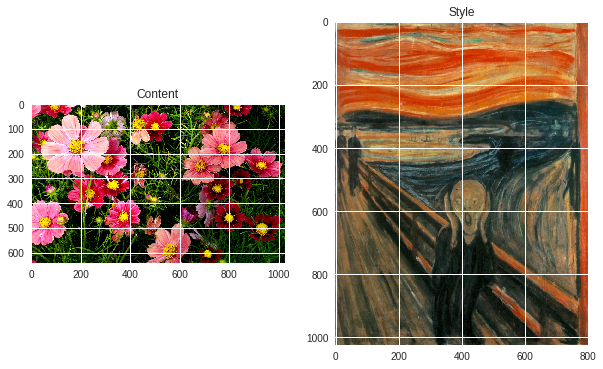

TypeError: ignored

In [22]:
PATH = os.getcwd()
IMAGES_PATH = PATH + '/Images'
VIDEOS_PATH = PATH + '/Videos'
MODELS_PATH = PATH + '/Models'
RESULTS_PATH = PATH + '/Results'


def find_file(filename, directory):
    for file in os.listdir(directory):
        if os.path.splitext(file)[0] == filename:
            return file

    raise Exception("File not found")

    
def create_directory(path):
    
    if not(os.path.isdir(path)):
            os.mkdir(path)
  
  
def upload_files(path,number, message):
    
    while(len(os.listdir(path))<number):
            print("Please upload at least "+message)
            os.chdir(path)
            files.upload()
       
      
def list_files(path):
  
    for file in os.listdir(Path(path)):
            print(os.path.splitext(file)[0])
        
        

if __name__ == "__main__":

    #tf.enable_eager_execution()
    #print("Eager execution: {}".format(tf.executing_eagerly()))
        
    choice = input("Select one of the following options:\n"
                    "1 - Style Transfer for Images\n"
                    "2 - Style Transfer for Videos\n")

    
    if choice == '1':

        create_directory(IMAGES_PATH)
        upload_files(IMAGES_PATH,2,"two images")

        print("Select Content Image:")

        list_files(IMAGES_PATH)

        content = find_file(input(),Path(IMAGES_PATH))
        content_path  = Path(IMAGES_PATH + "/" + content)

        print("Select Style Image:")

        list_files(IMAGES_PATH)

        style = find_file(input(),Path(IMAGES_PATH))
        style_path = Path(IMAGES_PATH + "/" + style)
        
        os.chdir(PATH)
        create_directory(RESULTS_PATH)
        
        output =  'Result' + '_' + os.path.splitext(content)[0] + '_' + os.path.splitext(style)[0]
        output_path = Path(RESULTS_PATH + "/" + output + ".jpg")

        show_content_style(content_path, style_path)

        best_img, best_loss = image_style_transfer(content_path, style_path, output_path, iterations=5000)

        print("Final Loss: " + best_loss.numpy())
        show_image(best_img, output)
        plt.show()

        print("image saved in Results folder")
        
        files.download(output+'.jpg')


    if choice == '2':
      
        create_directory(VIDEOS_PATH)
        upload_files(VIDEOS_PATH,1,"one video")
   
        print("Select Content Video:")

        list_files(VIDEOS_PATH)
        
        content = find_file(input(),Path(VIDEOS_PATH))
        content_path  = Path(VIDEOS_PATH + "/" + content)

        create_directory(MODELS_PATH)
        upload_files(MODELS_PATH,1,"one model")

        print("Select Style Model:")

        list_files(MODELS_PATH)

        model = find_file(input(),Path(MODELS_PATH))
        model_path = Path(MODELS_PATH + "/" + model)

        os.chdir(PATH)
        create_directory(RESULTS_PATH)
        
        output =  'Result' + '_' + os.path.splitext(content)[0] + '_' + os.path.splitext(model)[0]
        output_path = Path(RESULTS_PATH + "/" + output + ".mp4")

        video_style_transfer(str(content_path), str(model_path), str(output_path), batch_s=4)

        print("video saved in Files folder, refresh to see it")
        
        files.download(output+'.mp4')